In [41]:
# Shuffle data and tokenize headline column

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import sys

import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from collections import Counter

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Combine both datasets into one dataframe
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
data = pd.merge(data, pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True))
data.shape[0]

26712

# EDA and data cleaning

In [6]:
# Split into train, validation, and test - 80% train, 10% validation, 10% test
train_df, test_df = train_test_split(data, test_size=0.2)
test_df, validation_df = train_test_split(test_df, test_size=0.5)

In [7]:
print(train_df.shape[0])
print(validation_df.shape[0])
print(test_df.shape[0])

21369
2672
2671


In [8]:
train_df.head()

,article_link,headline,is_sarcastic
4223,https://www.huffingtonpost.com/entry/john-avil...,"john avildsen, oscar-winning director of 'rock...",0
11876,https://www.theonion.com/u-s-negotiating-mubar...,u.s. negotiating mubarak's severance package,1
17026,https://politics.theonion.com/biden-forges-pre...,biden forges president's signature on executiv...,1
127,https://www.huffingtonpost.com/entry/seattle-m...,seattle mayor's accuser in sex-abuse lawsuit c...,0
25083,https://www.theonion.com/report-only-47-000-so...,"report: only 47,000 social justice milestones ...",1


In [9]:
# Reset index to perform analysis.
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/john-avil...,"john avildsen, oscar-winning director of 'rock...",0
1,https://www.theonion.com/u-s-negotiating-mubar...,u.s. negotiating mubarak's severance package,1
2,https://politics.theonion.com/biden-forges-pre...,biden forges president's signature on executiv...,1
3,https://www.huffingtonpost.com/entry/seattle-m...,seattle mayor's accuser in sex-abuse lawsuit c...,0
4,https://www.theonion.com/report-only-47-000-so...,"report: only 47,000 social justice milestones ...",1


In [10]:
# Find corpus size...borrowed concepts from my code from a HW assignment
num_words = 0
word_list = []
num_word_list = []
for i in range(0, len(train_df)):
  words = train_df['headline'][i].split()
  word_list.extend(words)
  num_word_list.append(len(words))
  num_words = num_words + len(words)
print(num_words)

# Vocabulary size.
vocab_list = nltk.lm.Vocabulary(word_list)
print(len(vocab_list))

210652
32258


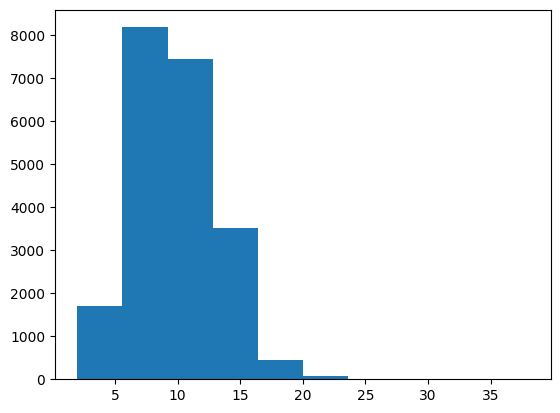

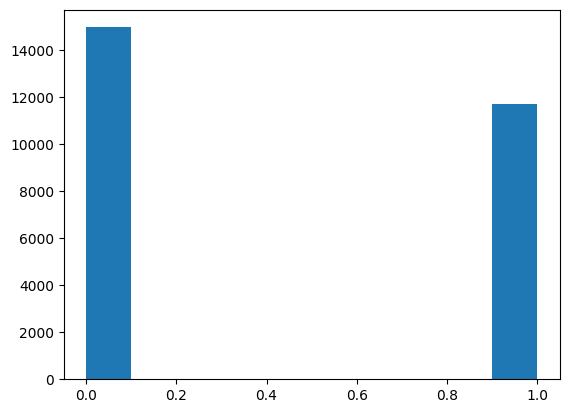

Average words per title: 9.857831438064485
Minimum words per title: 2
Maximum words per title: 39
Sarcastic to serious ratio: 0.4389412997903564


In [11]:
# Borrowed some concepts from my HW code

# Words per title
plt.hist(num_word_list)
plt.show()

# Plot class distribution
plt.hist(data['is_sarcastic'])
plt.show()

print('Average words per title: ' + str(sum(num_word_list) / len(num_word_list)))
print('Minimum words per title: ' + str(data['headline'].str.split().apply(len).min()))
print('Maximum words per title: ' + str(data['headline'].str.split().apply(len).max()))
print('Sarcastic to serious ratio: ' + str(data['is_sarcastic'].sum()/data['is_sarcastic'].shape[0]))

In [12]:
# Remove article link
train_df.drop(labels='article_link', axis=1, inplace=True)
validation_df.drop(labels='article_link', axis=1, inplace=True)
test_df.drop(labels='article_link', axis=1, inplace=True)
train_df.shape[0]

21369

In [13]:
# Drop duplicate rows
train_df.drop_duplicates(inplace=True)
validation_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

train_df.shape[0]

21296

In [14]:
# Drop rows with NA values
train_df.dropna(inplace=True)
validation_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df.shape[0]

21296

In [15]:
# Ensure the is_sarcastic column only contains 1s and 0s
train_df[(train_df.is_sarcastic <= 1)]
train_df[(train_df.is_sarcastic >= 0)]
validation_df[(validation_df.is_sarcastic <= 1)]
validation_df[(validation_df.is_sarcastic >= 0)]
test_df[(test_df.is_sarcastic <= 1)]
test_df[(test_df.is_sarcastic >= 0)]

train_df.shape[0]

21296

In [16]:
# Reset index after data cleaning
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [17]:
# Remove stop words
stop_words = set(stopwords.words('english'))

for i in range(0, train_df['headline'].shape[0]):
  words = train_df['headline'][i].split()
  removed_stop_words = [x for x in words if not x.lower() in stop_words]
  train_df['headline'][i] = ' '.join(removed_stop_words)

for i in range(0, validation_df['headline'].shape[0]):
  words = validation_df['headline'][i].split()
  removed_stop_words = [x for x in words if not x.lower() in stop_words]
  validation_df['headline'][i] = ' '.join(removed_stop_words)

for i in range(0, test_df['headline'].shape[0]):
  words = test_df['headline'][i].split()
  removed_stop_words = [x for x in words if not x.lower() in stop_words]
  test_df['headline'][i] = ' '.join(removed_stop_words)

In [18]:
# Remove short titles
for i in range(0, train_df['headline'].shape[0]):
  if len(train_df['headline'][i]) < 5:
    train_df.drop(i, axis=0)

for i in range(0, validation_df['headline'].shape[0]):
  if len(validation_df['headline'][i]) < 5:
    validation_df.drop(i, axis=0)

for i in range(0, test_df['headline'].shape[0]):
  if len(test_df['headline'][i]) < 5:
    test_df.drop(i, axis=0)

In [19]:
# Reset indices after data processing
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [20]:
# Tokenize the headline column so that the model can understand the input.
tk_train = Tokenizer()
tk_train.fit_on_texts(train_df['headline'])
train_df['headline_tokenized'] = tk_train.texts_to_sequences(train_df['headline'])

tk_valid = Tokenizer()
tk_valid.fit_on_texts(validation_df['headline'])
validation_df['headline_tokenized'] = tk_valid.texts_to_sequences(validation_df['headline'])

tk_test = Tokenizer()
tk_test.fit_on_texts(test_df['headline'])
test_df['headline_tokenized'] = tk_test.texts_to_sequences(test_df['headline'])

# LSTM model

I used this link for inspiration on the model design: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [21]:
# This type of model requires a fixed width column, so ensure all columns are same width
train_pad = max(len(x) for x in train_df.headline_tokenized)
validation_pad = max(len(x) for x in validation_df.headline_tokenized)
test_pad = max(len(x) for x in test_df.headline_tokenized)
pad_len = max(train_pad, validation_pad, test_pad)

In [22]:
train_df['headline_tokenized'] = pad_sequences(train_df['headline_tokenized'], maxlen=pad_len)
x_train = np.reshape(train_df['headline_tokenized'].values, (-1,1))
y_train = np.reshape(train_df['is_sarcastic'].values, (-1,1))

validation_df['headline_tokenized'] = pad_sequences(validation_df['headline_tokenized'], maxlen=pad_len)
x_valid = np.reshape(validation_df['headline_tokenized'].values, (-1,1))
y_valid = np.reshape(validation_df['is_sarcastic'].values, (-1,1))

test_df['headline_tokenized'] = pad_sequences(test_df['headline_tokenized'], maxlen=pad_len)
x_test = np.reshape(test_df['headline_tokenized'].values, (-1,1))
y_test = np.reshape(test_df['is_sarcastic'].values, (-1,1))

In [23]:
lstm_model = Sequential()
lstm_model.add(Embedding(train_df.shape[0], 64, input_length=None))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1362944   
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,429,045
Trainable params: 1,429,045
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
lstm_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=2, batch_size=64)

Epoch 1/2
333/333 [==============================] - 11s 24ms/step - loss: 0.6867 - accuracy: 0.5595 - val_loss: 0.6820 - val_accuracy: 0.5746
Epoch 2/2
333/333 [==============================] - 7s 20ms/step - loss: 0.6862 - accuracy: 0.5601 - val_loss: 0.6828 - val_accuracy: 0.5746


In [42]:
sys.getsizeof(lstm_model)

48

### Results

In [27]:
results = lstm_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: " + str((results[1]*100)))

Accuracy: 56.21722936630249


# Decision Tree Model

##### Borrowed code from one of my HW assignments

In [28]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [29]:
print('Mean accuracy: ' + str(cross_val_score(decision_tree, x_valid, y_valid).mean() * 100))

Mean accuracy: 57.45873474292219


In [30]:
print(decision_tree.score(x_test, y_test) * 100)

56.21722846441948


In [44]:
sys.getsizeof(decision_tree)

48

# Logistic Regression Model

#### Borrowed code from one of my HW assignments

In [45]:
logistic_regression = linear_model.LogisticRegression()
logistic_regression.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [46]:
print('Mean accuracy: ' + str(cross_val_score(logistic_regression, x_valid, y_valid).mean() * 100))

Mean accuracy: 57.45873474292219


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [47]:
print(logistic_regression.score(x_test, y_test) * 100)

56.21722846441948


In [49]:
sys.getsizeof(logistic_regression)

48